Notebook Logistic Regression Case
Oefening Data Scientist 
Geert Vandezande

Doel:
- Supervised Learning toepassen
- EDA uitvoeren op een dataset
- Lineair Regression toepassen op de data

Dataset: 
- More info: see kaggle https://www.kaggle.com/datasets/arifmia/heart-attack-risk-dataset


Volgorde van activiteiten in deze notebook: (cfr Datacamp "preparing data for modelling)
- data inlezen
- data bekijken, visueel en numerisch
- missing data oplossen 
- incorrect types controleren
- Numerische waarde standardizeren
- Categorische varaiabelen processen
- Feature engineering
- select features for modelling

In [138]:
# import van de diverse modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import plot_importance

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

In [139]:
# extra code overal gebruikt

# extra code – code to save the figures as high-res PNGs for the book
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



def plot_overzicht_kolommen(df_plot, num_columns = 3, figuur_naam = 'Overzicht kolommen', bins = 50):    
    num_plots = len(df_plot.columns)
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    for i, column in enumerate(df_plot.columns):
        df_plot[column].hist(bins, ax=axes[i])
        axes[i].set_title(column)
    # Hide any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    save_fig(figuur_naam)
    plt.show()


def plot_histogram(df_hist, column, bins = 50, figuur_naam = 'Overzicht kolommen'):
    plt.rc('font', size=14)
    plt.rc('axes', labelsize=14, titlesize=14)
    plt.rc('legend', fontsize=14)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    # plt.hist(df_hist[column], color='blue', alpha=0.7)
    plt.title('Histogram van Heart Rate')
    plt.xlabel('Heart Rate')
    plt.ylabel('Frequentie')
    df_hist[column].hist(bins, figsize=(12, 8))
    save_fig(figuur_naam)  # extra code
    plt.show()

In [165]:
# data inlezen van de file

df = pd.read_csv('data/heart_attack_risk_dataset.csv')

# lijst met features opgedeeld in numerisch en categorisch
df_col = ['Age', 'Gender', 'Smoking', 'Alcohol_Consumption',
       'Physical_Activity_Level', 'BMI', 'Diabetes', 'Hypertension',
       'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Family_History',
       'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar',
       'ECG_Results', 'Exercise_Induced_Angina', 'Max_Heart_Rate_Achieved',
       'Heart_Attack_Risk']

# Seperate numeric and categorical columns
df_num_col = df.select_dtypes(include='number').columns
df_cat_col = df.select_dtypes(include='object').columns

# df_col_num = ['Age', 'BMI', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Max_Heart_Rate_Achieved']

# df_col_cat = ['Gender', 'Smoking', 'Alcohol_Consumption', 'Physical_Activity_Level', 'Diabetes', 'Hypertension', 'Family_History', 'Stress_Level',
#               'Chest_Pain_Type', 'Thalassemia', 'Fasting_Blood_Sugar','ECG_Results', 'Exercise_Induced_Angina', 'Heart_Attack_Risk']

df_num = df[df_num_col]
df_cat = df[df_cat_col]
print(df_num.head())
print(df_cat.head())



   Age  Smoking  Alcohol_Consumption    BMI  Diabetes  Hypertension  \
0   69        1                    0  34.61         1             0   
1   32        0                    0  22.75         0             0   
2   89        0                    1  35.32         0             0   
3   78        0                    1  18.23         1             0   
4   38        1                    0  19.82         0             0   

   Cholesterol_Level  Resting_BP  Heart_Rate  Family_History  \
0              152.1         171          85               0   
1              166.8         126         103               0   
2              272.3         123         127               0   
3              237.7         144         125               0   
4              207.7         123         107               0   

   Fasting_Blood_Sugar  Exercise_Induced_Angina  Max_Heart_Rate_Achieved  
0                    0                        0                      114  
1                    0                

In [161]:
# eerste controles

df.head()
df.describe()
df.info()

print(df.columns)

# check op nulwaarden:
df.isnull().sum()
# ok, geen nulwaarden

df.duplicated().sum()
# ok, geen duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      50000 non-null  int64  
 1   Gender                   50000 non-null  object 
 2   Smoking                  50000 non-null  int64  
 3   Alcohol_Consumption      50000 non-null  int64  
 4   Physical_Activity_Level  50000 non-null  object 
 5   BMI                      50000 non-null  float64
 6   Diabetes                 50000 non-null  int64  
 7   Hypertension             50000 non-null  int64  
 8   Cholesterol_Level        50000 non-null  float64
 9   Resting_BP               50000 non-null  int64  
 10  Heart_Rate               50000 non-null  int64  
 11  Family_History           50000 non-null  int64  
 12  Stress_Level             50000 non-null  object 
 13  Chest_Pain_Type          50000 non-null  object 
 14  Thalassemia           

np.int64(0)

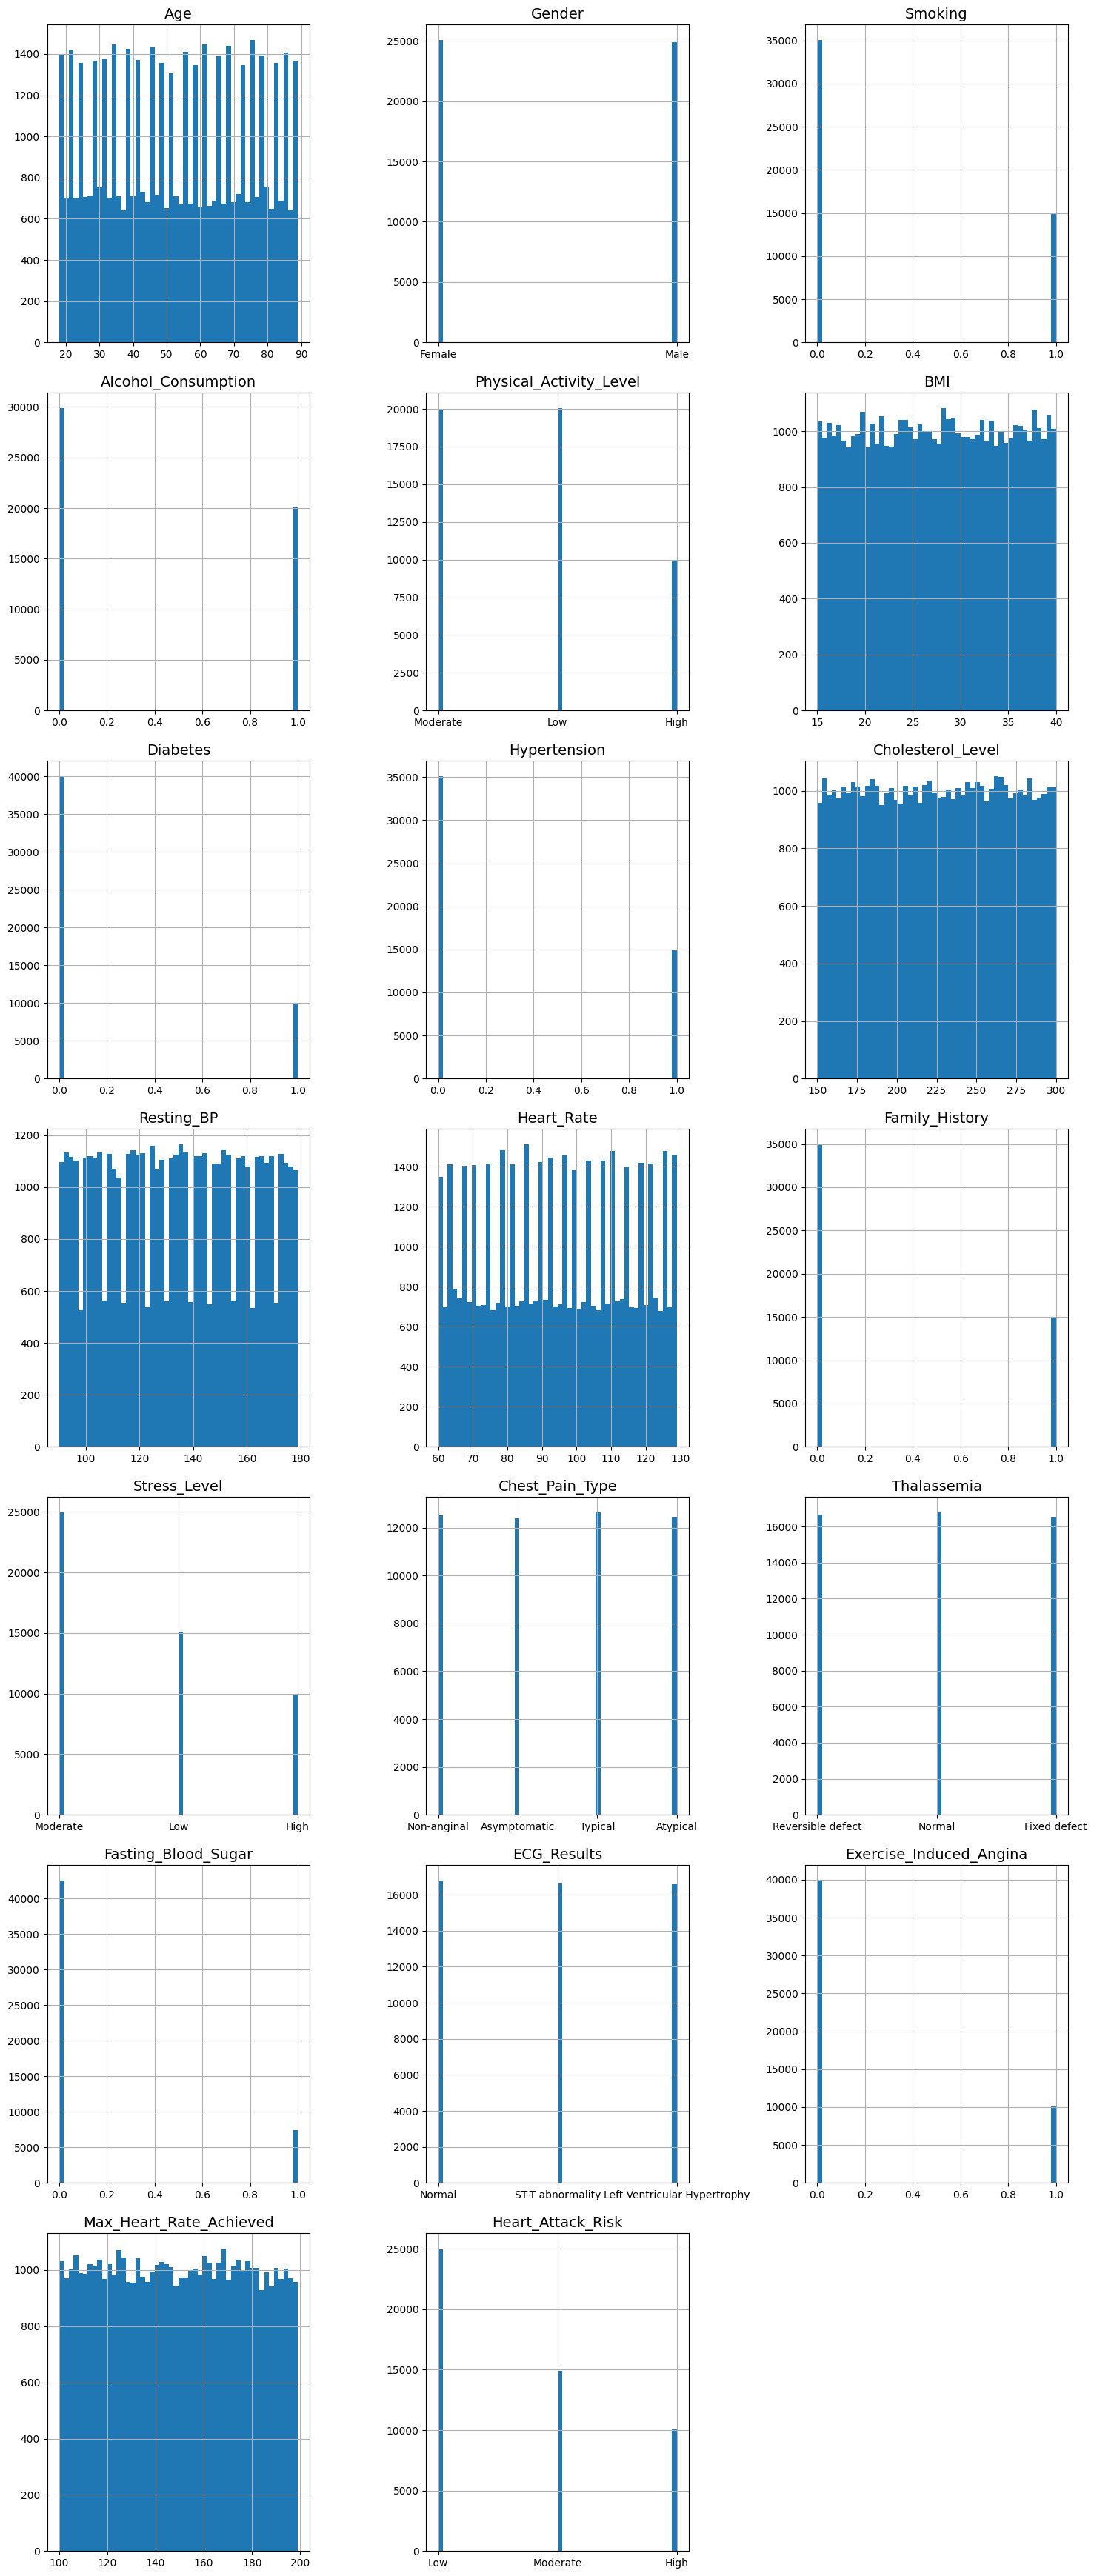

In [162]:
# snelle blik op de variabelen
# algemene plot van de variabelen

num_columns = 3
num_plots = len(df.columns)
num_rows = (num_plots + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))
axes = axes.flatten()
for i, column in enumerate(df.columns):
    df[column].hist(bins=50, ax=axes[i])
    axes[i].set_title(column)
# Hide any unused subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
save_fig("algemeen_overzicht_features")
plt.show()

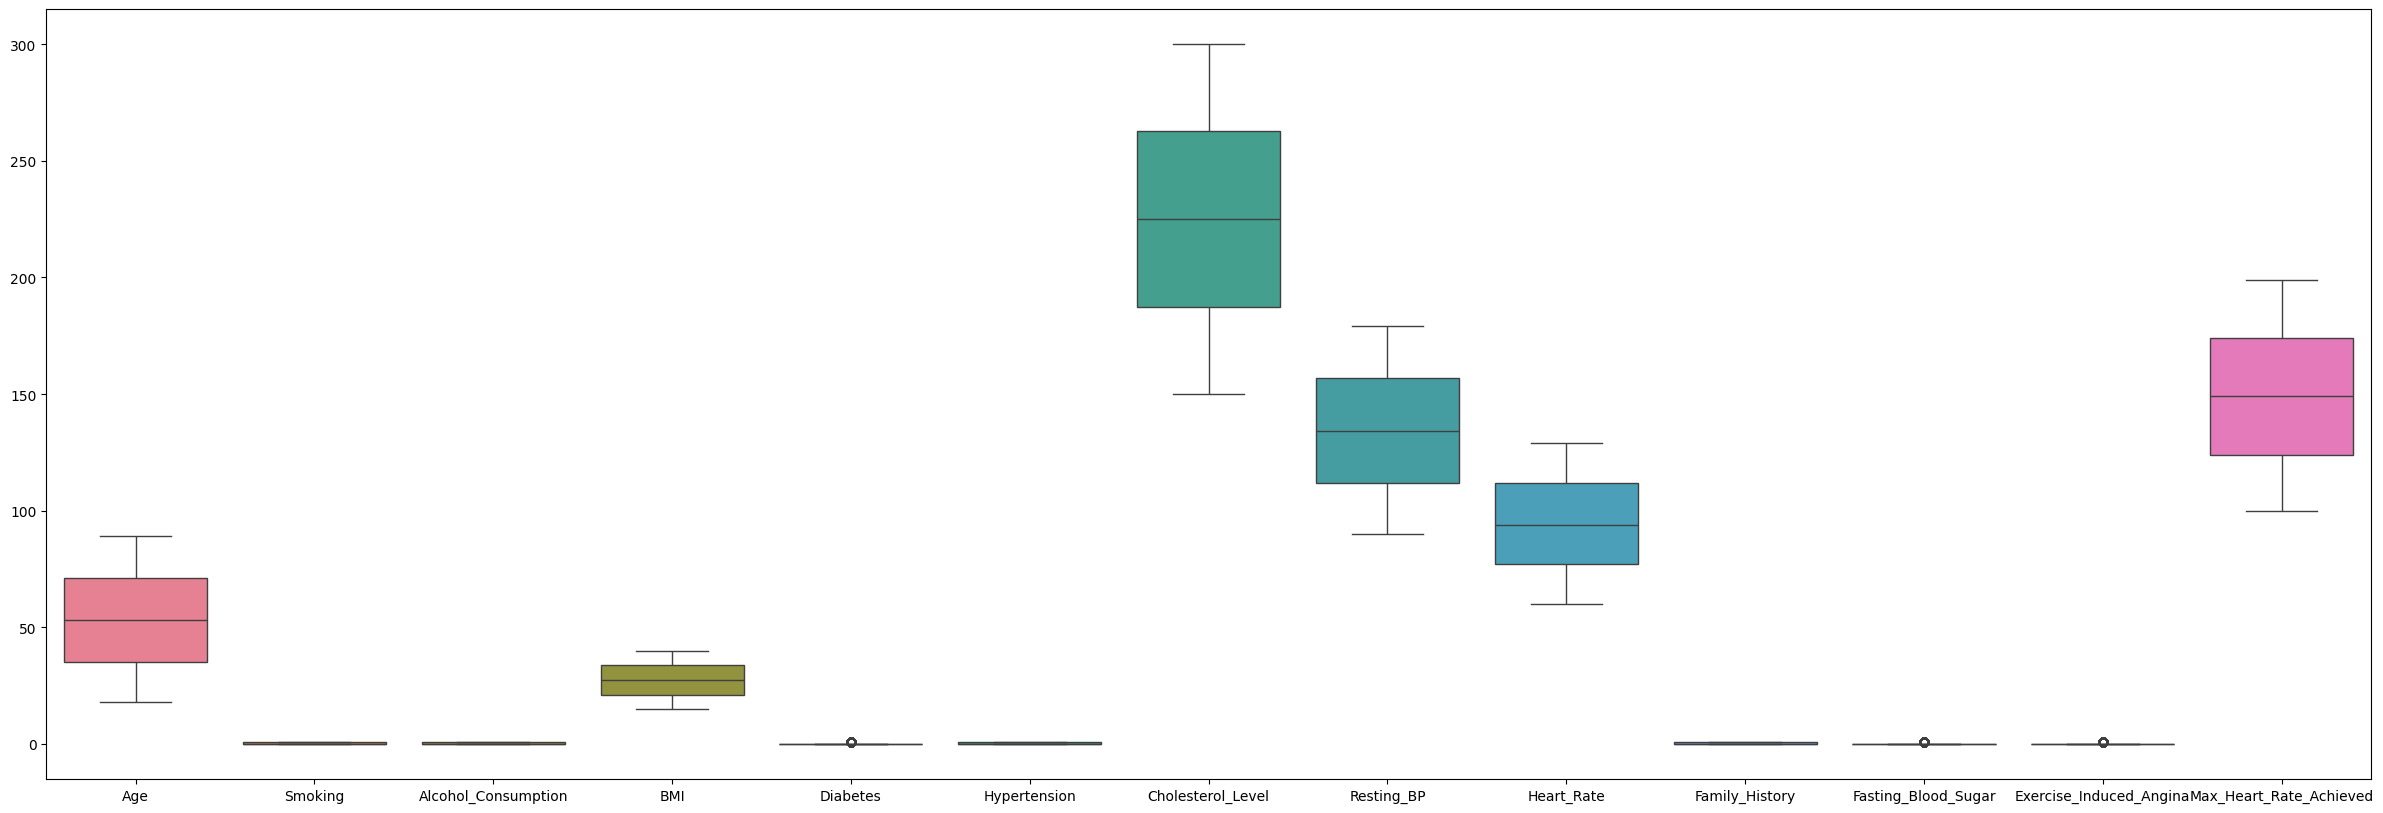

C:\Users\geert\AppData\Local\Temp\ipykernel_38016\68602168.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38016\68602168.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38016\68602168.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38016\68602168.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppData\Local\Temp\ipykernel_38016\68602168.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df[col], kde=True, palette='skyblue')
C:\Users\geert\AppDa

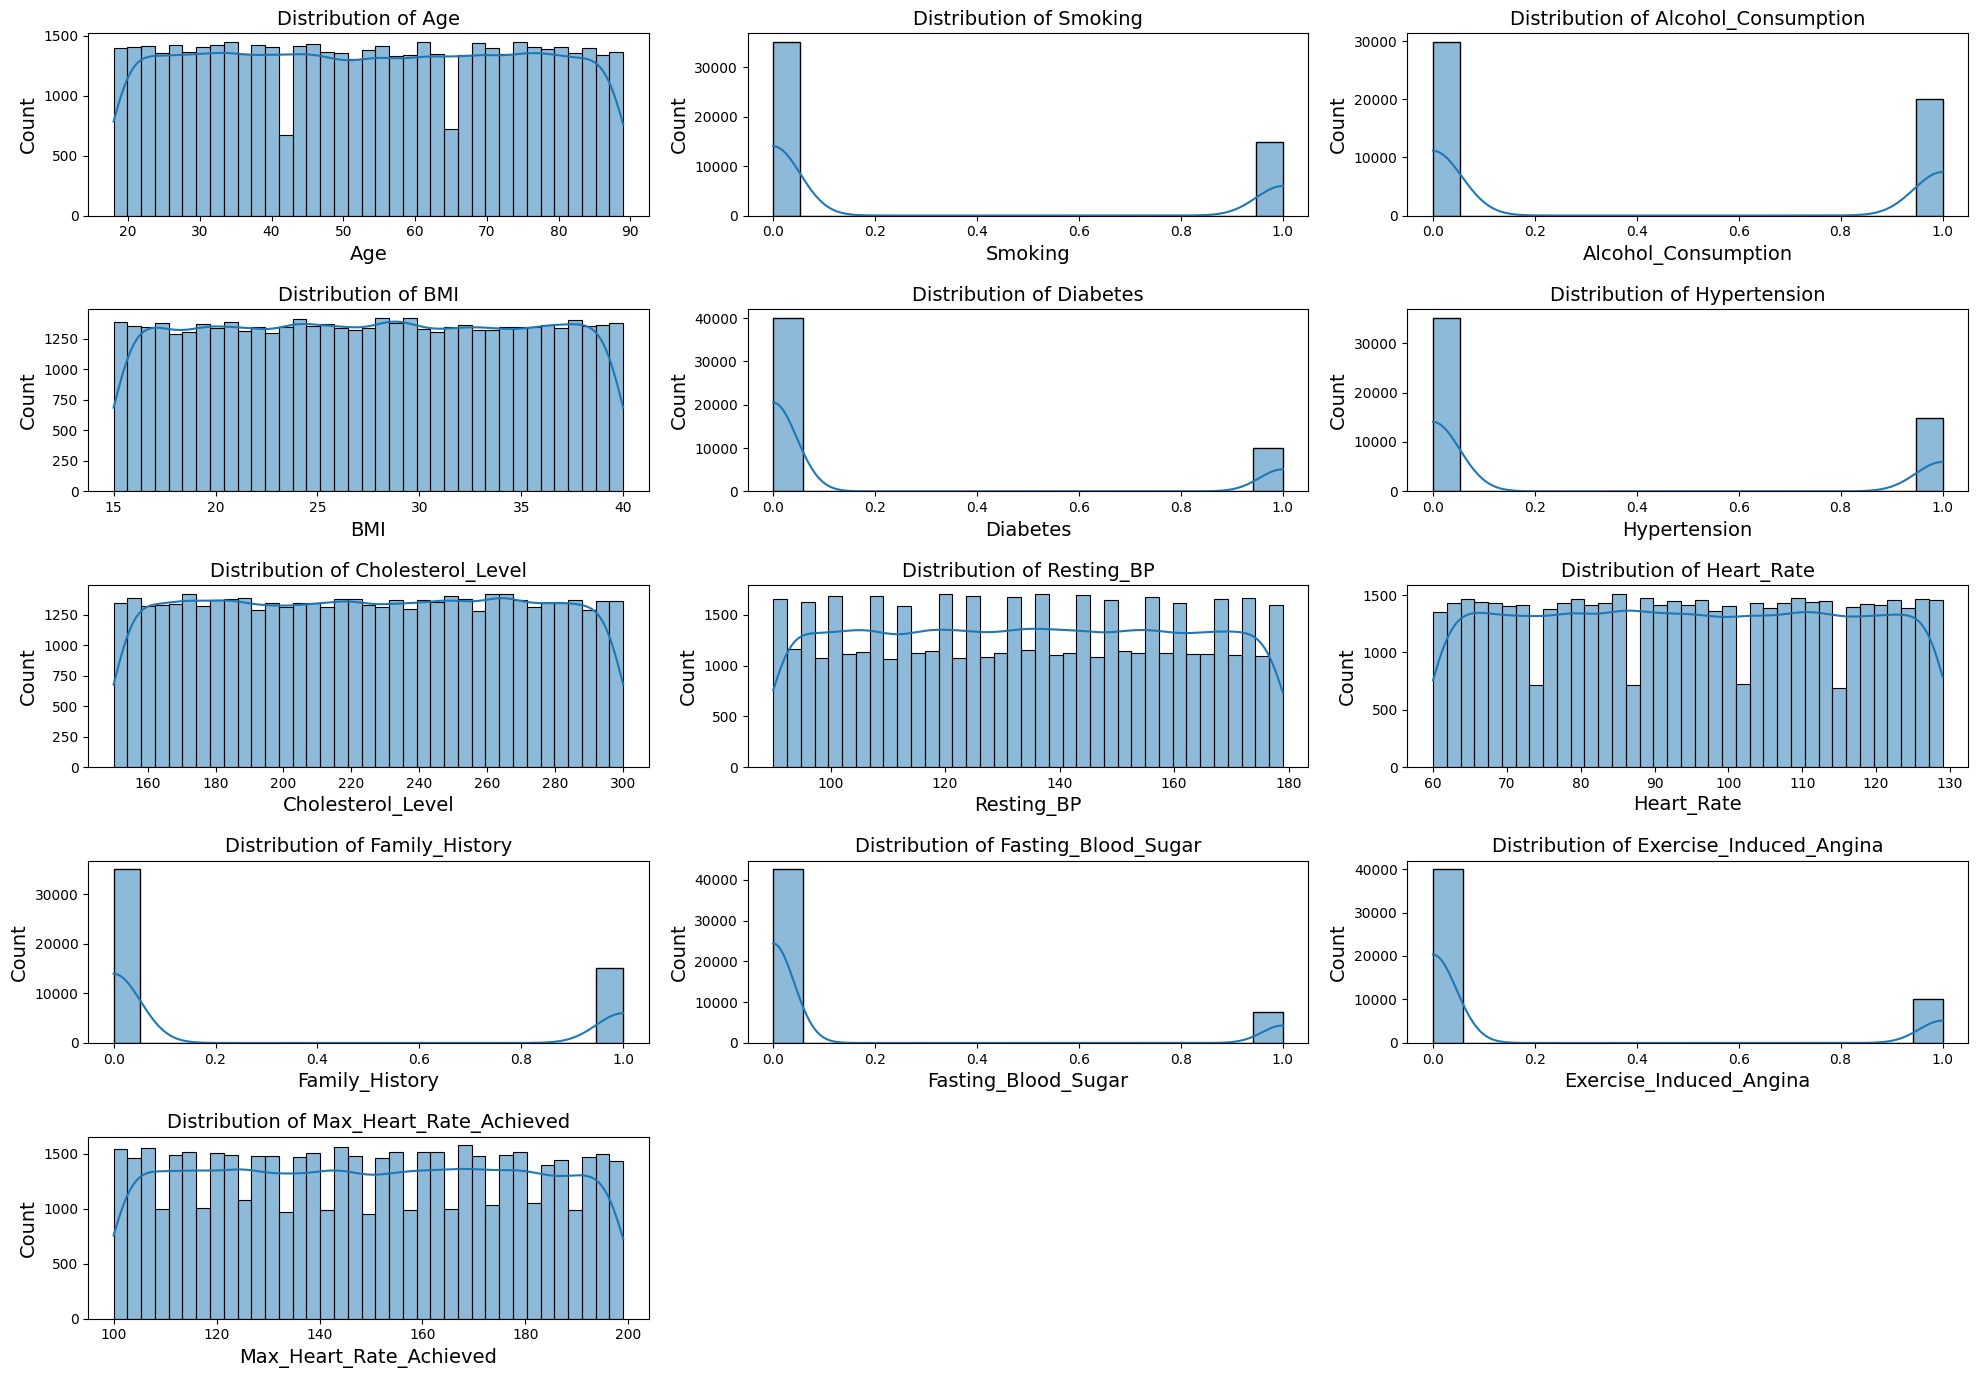

In [166]:
# analyze van de features, eerst de numerische features
# eerst een boxplot, voor de numerische waarde

fig = plt.figure(figsize=(30,10))
sns.boxplot(df_num)
plt.show()

# dan de variantie
df_num.describe()


plt.figure(figsize=(20,14))

for i, col in enumerate(df_num_col,1):
    plt.subplot(5,3,i)
    sns.histplot(df[col], kde=True, palette='skyblue')
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()






   Gender Physical_Activity_Level Stress_Level Chest_Pain_Type  \
0  Female                Moderate     Moderate     Non-anginal   
1    Male                Moderate          Low    Asymptomatic   
2    Male                Moderate          Low         Typical   
3    Male                Moderate          Low         Typical   
4  Female                Moderate         High    Asymptomatic   

         Thalassemia                   ECG_Results Heart_Attack_Risk  
0  Reversible defect                        Normal               Low  
1             Normal              ST-T abnormality          Moderate  
2  Reversible defect              ST-T abnormality               Low  
3       Fixed defect  Left Ventricular Hypertrophy               Low  
4  Reversible defect              ST-T abnormality          Moderate  


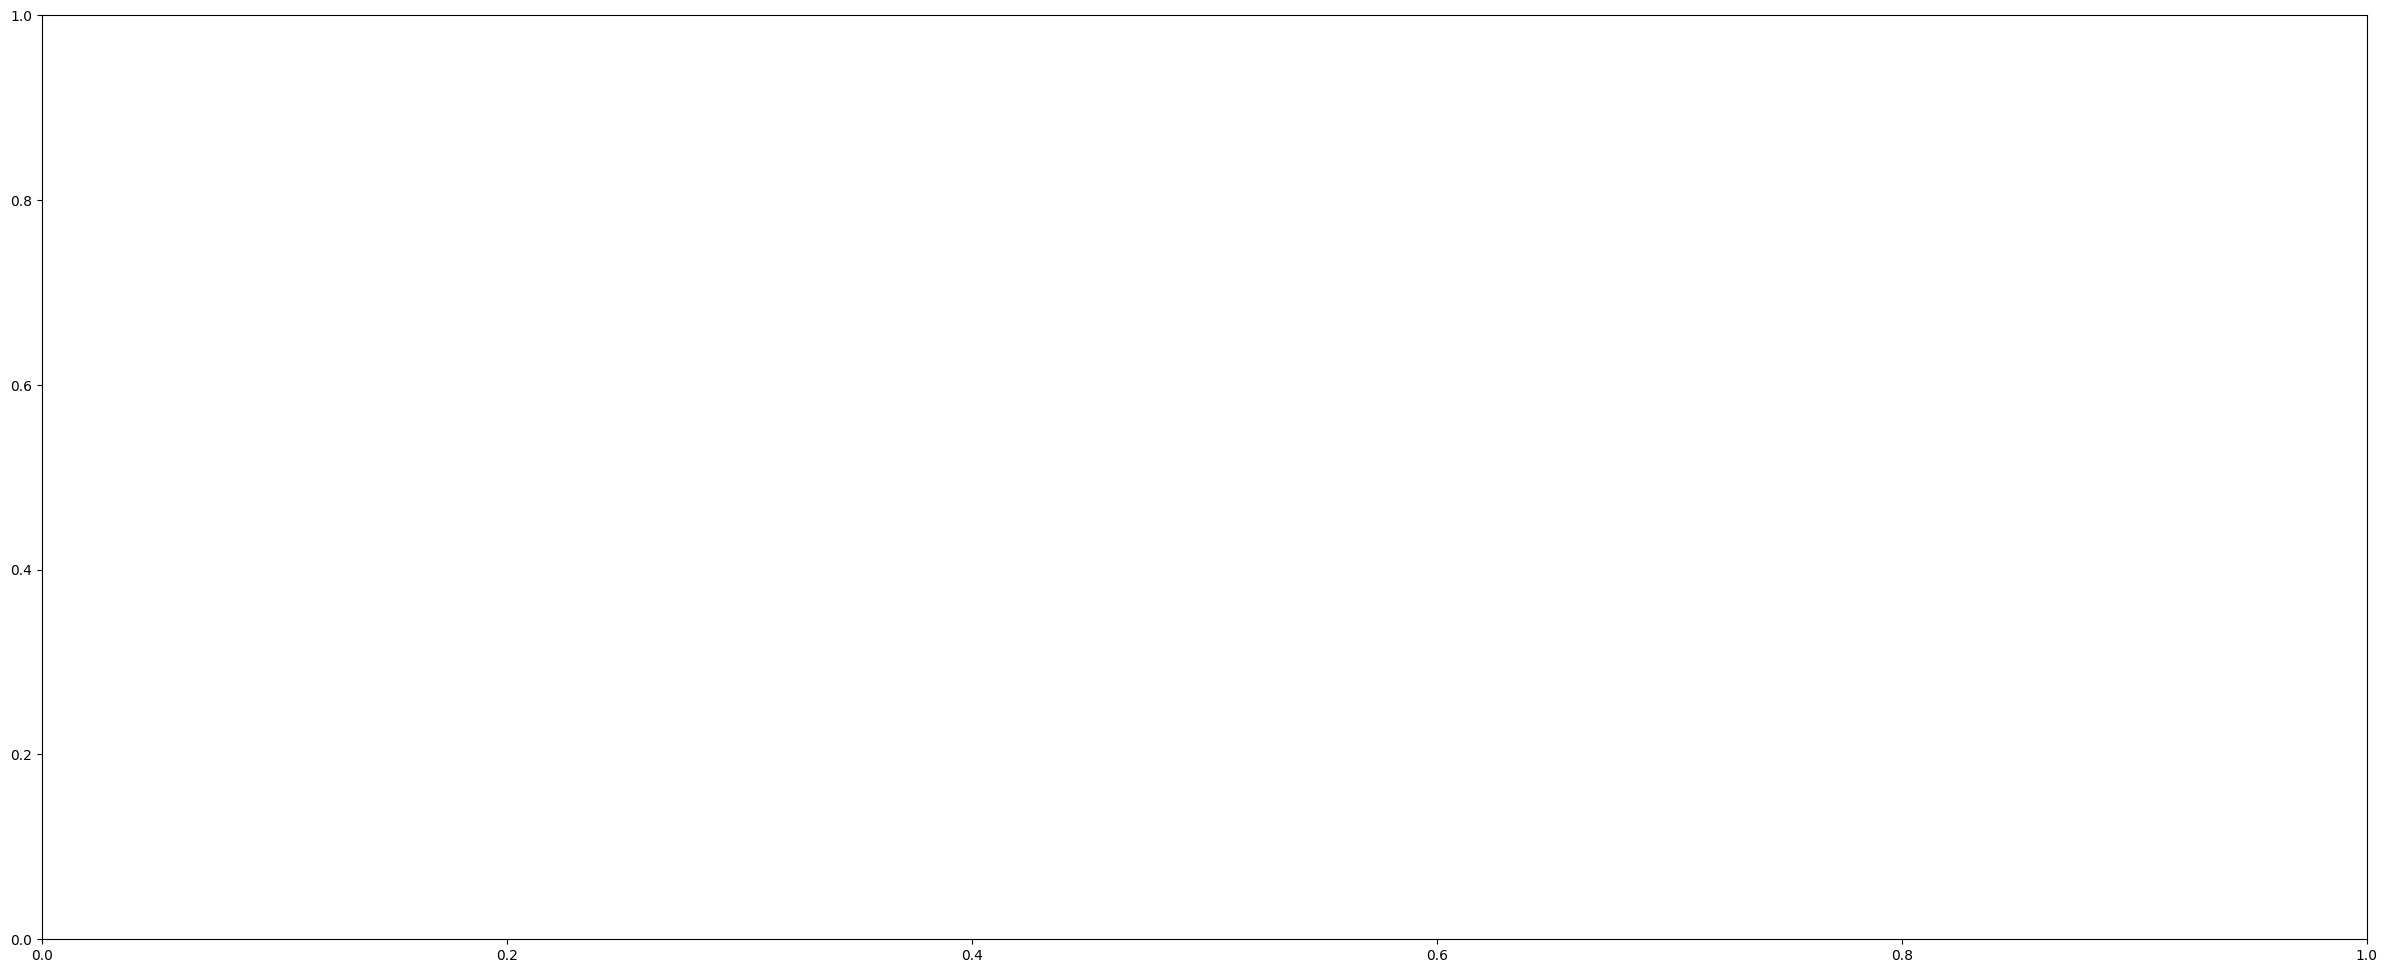

,Gender,Physical_Activity_Level,Stress_Level,Chest_Pain_Type,Thalassemia,ECG_Results,Heart_Attack_Risk
count,50000,50000,50000,50000,50000,50000,50000
unique,2,3,3,4,3,3,3
top,Female,Low,Moderate,Typical,Normal,Normal,Low
freq,25086,20061,24971,12642,16797,16799,25024


In [164]:
# analyze van de features, eerst de categorische features
# eerst een boxplot


print(df_cat.head())

fig = plt.figure(figsize=(30,12))
sns.boxplot(df_cat)
plt.show()

# dan de variantie
df_cat.describe()

In [149]:
# Create correaltion heatmap
fig = plt.figure(figsize=(30,30))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show()

ValueError: could not convert string to float: 'Female'

<Figure size 3000x3000 with 0 Axes>